# Aprendizaje Automático

## Práctica 7: Redes neuronales y clasificación de dígitos

En esta práctica vamos a tratar con el problema de reconocimiento de dígitos para lo cual implementaremos una red neuronal, con la propagación hacia adelante y hacia atrás. Además, implementaremos las versiones con y sin regularización de la función de coste y la inicialización aleatoria de los pesos. Finalmente, utilizaremos la red para realizar predicciones.

## Índice de la práctica

- [Lectura y visualización de datos](#lectura)
- [Implementación de una Red Neuronal Multicapa](#red_multicapa)
    - [Propagación hacia adelante (feed-forward)](#forward)
        - [Función de coste](#cost)
        - [Función de coste con regularización](#cost_reg)
    - [Propagación hacia atrás (backpropagation)](#backprop)
    - [Propagación hacia atrás (backpropagation) con regularización](#backprop_reg)
- [Entrenamiento de la red y clasificación](#entrenamiento)
- [Tarea opcional](#Tarea-opcional)



Importamos todas las librerías que vamos a utilizar inicialmente. Posteriormente iremos importando las librerías específicas de cada apartado de la práctica.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

def test_nb(var, val, msg=""):
    if var == val:
        print("✔️ Test passed.")
    else:
        print("❌ Test failed. " + msg)
        raise AssertionError(msg)


%matplotlib inline

## Lectura y visualización de datos <a id="lectura"></a>

El conjunto de datos está disponible en el fichero `mnist.txt` que como siempre leeremos con `loadtxt` (delimitado por comas). El conjunto de datos tiene 5000 ejemplos. La última columna contiene la clase (los dígitos de 0 a 9).

In [3]:
# Lee los datos y guárdalos en data
data = np.loadtxt("mnist.txt", delimiter=",")
X = data[:, :-1]
y = data[:, -1].reshape(-1, 1)
print(X.shape, y.shape)

(5000, 400) (5000, 1)


Para comprender mejor el problema con el que tratamos, vamos a comenzar mostrando los ejemplos que tenemos. Cada ejemplo está formado por 400 características, que son realmente las intensidades de cada píxel de una imagen de 20x20. Vamos a comprobar que esto es así mostrando diez ejemplos aleatorios (puedes ejecutar varias veces el código para ver diferentes ejemplos). En el título, aparece la clase real del ejemplo en cuestión.

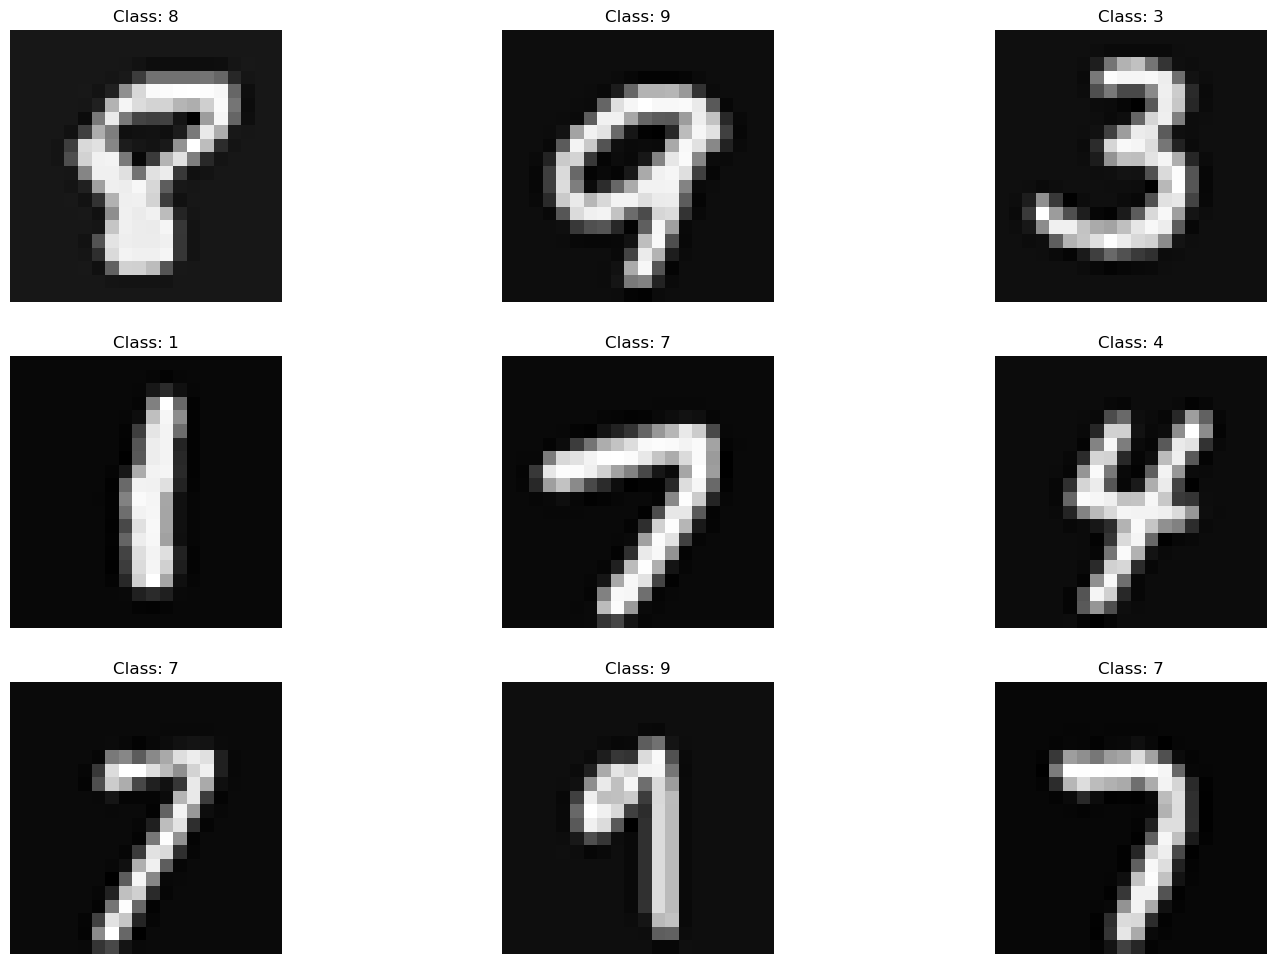

In [4]:
size = 9
col = 3
row = int(np.ceil(size / col))
fig, axes = plt.subplots(row, col, figsize=(18, row * 4))

for degree in range(size):
    index = np.random.randint(0, X.shape[0])
    img = X[index, :].reshape(20, 20, order='F')
    axes.ravel()[degree].imshow(img, cmap=plt.cm.gray)
    axes.ravel()[degree].set_title(f'Class: {int(y.flat[index])}')
    axes.ravel()[degree].axis('off')

¿Seremos capaces de entrenar una red que pueda distinguir el dígito que aparece en la imagen? Lo veremos a lo largo de la práctica.

## Implementación de una Red Neuronal Multicapa <a id="red_multicapa"></a>

Como hemos visto en teoría, para trabajar con problemas multi-clase con redes neuronales necesitamos transformar la salida que es un solo valor (la clase) a un vector de 0s y 1s, en donde el 1 en la posición correspondiente nos indique a qué clase pertenece el ejemplo. Esto es necesario ya que vamos a tener una neurona de salida para cada una de las clases.

### Transformación One-hot para la salida
Para lograr esta transformación vamos a usar el método [`OneHotEncoder` de scikit](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), que hace precísamente esa tarea. One-hot enconding convierte una etiqueta de clase $n$ (de entre $k$ clases) en un vector de longitud $k$ donde el índice $n$ está "hot" (activado, es decir, a 1), mientras que el resto están a 0.

In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
# Aplica el fit_transform de scikit a y para obtener el nuevo y_onehot
y_onehot = encoder.fit_transform(y)
print(y_onehot.shape)
print(y[0], y_onehot[0,:])

(5000, 10)
[0.] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
test_nb(list(y_onehot[0,:]), [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], 'One-hot encoding incorrecto')

✔️ Test passed.


### Arquitectura de la red neuronal
La red neuronal que vamos a construir para este ejercicio tiene tantas neuronas de entrada como características tienen nuestros ejemplos (400 + la unidad de bias). La capa oculta tendrá 25 neuronas (26 con el bias), y la capa de salida tendrá 10 neuronas, que cada una de ellas corresponde a una de las clases. 

Lo primero que debemos haces es implementar la función de coste para evaluar el coste para un conjunto de parámetros dado. Para ello, primero necesitamos aplicar la propagación hacia adelante, que nos de la salida para cada ejemplo de entrada.

Vamos por pasos. Comenzamos implementando la función sigmoide.

$$ g(z) = \frac{1}{1+e^{-z}} $$

In [7]:
def sigmoid(z):
    return 1/(1+np.e**(-z))

### Propagación hacia adelante - feed-forward <a id="forward"></a>
A continuación, vamos a calcular la propagación hacia adelante. Para ello, recibimos la matriz con los datos $X$ y las dos matrices de pesos $\Theta^{(1)}$ y $\Theta^{(2)}$ (los pesos entre la capa de entrada y la capa oculta y los pesos entre la capa oculta y la de salida, respectivamente).

Debemos seguir los siguientes pasos:
1. Añadir el bias a todos los ejemplos de $X$ (la primera columna de 1s). Recordemos que tenemos 5000 ejemplos. Obtenemos $a^{(1)}$
2. Obtenemos $z^{(2)}=a^{(1)}·\Theta^{(1)^T}$
3. Obtenemos $a^{(2)}$ a partir de $z^{(2)}$ aplicando la sigmoide ($a^{(2)}=g(z^{(2)})$)  y le añadimos el bias (primera columna de 1s).
4. Obtenemos $z^{(3)}=a^{(2)}·\Theta^{(2)^T}$
5. Obtenemos $h_{\Theta}(X)=g(z^{(3)})$

En $h_{\Theta}(X)$ tenemos por tanto una matriz de $5000\times 10$ con las salidas de las 10 neuronas para cada uno de los 5000 ejemplos. La siguiente figura clarifica el proceso.

> **Nota:** La siguiente figura muestra el proceso, pero para un único ejemplo (un vector columna como ejemplo de entrada).

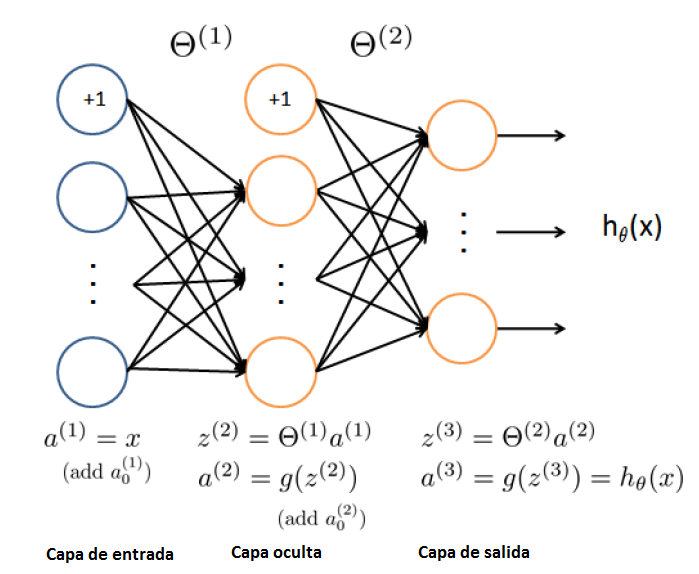

In [8]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    
    # Añadimos la columna de unos a X para obtener a1
    a1 = np.hstack((np.ones((m,1)), X))
    # Calculamos z2 -> ten en cuenta que a1 tiene tantas filas como ejemplos y columnas como atributos + 1
    # Por otro lado, theta1 tiene tantas filas como neuronas en la capa oculta y columnas como atributos + 1
    z2 = a1 @ theta1.T
    # Añadimos la columna de unos a la sigmoide de z2 (que es a2) para obtener el a2 definitivo
    a2 = sigmoid(z2)
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))
    # Calculamos z3
    z3 = a2 @ theta2.T
    # Obtenemos la salida final en h
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

Vamos a comprobar si la función funciona correctamente.

In [9]:
# Configuración inicial
input_size = 400
hidden_size = 25
num_labels = 10
np.random.seed(123456789)

theta1 = (np.random.rand(hidden_size, input_size + 1) - 0.5) * 0.25
theta2 = (np.random.rand(num_labels, hidden_size + 1) - 0.5) * 0.25

# Veamos si los tamaños de las matrices theta1 y theta2 son correctos
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [10]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
print(a1.shape, z2.shape, a2.shape, z3.shape, h.shape)

test_nb(list(np.round(h[55, :].tolist(), 4)), [ 0.4401, 0.5554, 0.3921, 0.4379,0.4063,  0.4987,  0.5222, 0.4887, 0.6124, 0.5376], 'Resultado de la propagación hacia adelante incorrecto')

(5000, 401) (5000, 25) (5000, 26) (5000, 10) (5000, 10)
✔️ Test passed.


#### Función de coste <a id="cost"></a>

Con la propagación hacia adelante, ya podemos calcular la función de coste:
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$

Aquí debemos tener cuidado porque para utilizar la función `minimize` de scipy, los parámetros $\Theta^{(1)}$ y $\Theta^{(2)}$ nos llegan en un único parámetro `params` y debemos desempaquetarlas. Además, hay que tener en cuenta que $y$ es una matriz de ejemplos x número de clases (5000x10 en este caso). Y por tanto, la salida que nos da la propagación hacia adelante (de 5000x10) y la $y$ serán directamente comparables. Recordemos que la función de coste nos da una estimación de cómo de diferentes son $y$ y $h_\Theta(X)$.

In [11]:
def cost(params, input_size, hidden_size, num_labels, X, y):
    m = X.shape[0]

    # desempaquetamos las matrices con los parámetros para cada capa
    theta1 = np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
    theta2 = np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))
    
    # Ejecutamos las propagación hacia adelante para obtener las salidas para cada ejemplo
    # a1, z2, a2, z3, h = ....
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

    # Calculamos el coste
    J = (1/m) * np.sum(-y*np.log(h)-(1-y)*np.log(1-h))

    return J

Vamos a comprobar que la función de coste funciona como debe.

In [12]:
# Configuración inicial
input_size = 400
hidden_size = 25
num_labels = 10
np.random.seed(123456789)

# Inicializamos los parámetros de la red aleatoriamente directamente en el formato de minimize
# El tamaño del array es el tamaño de las dos matrices de pesos concatenadas
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25

# Podemos desempaquetar los parámetros que acabamos de inicializar igual que lo hacemos en la función de coste
theta1 = np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
theta2 = np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))

# Veamos si los tamaños de las matrices theta1 y theta2 son correctos
theta1.shape, theta2.shape

((25, 401), (10, 26))

Llama a la función de coste para obtener el coste de la red neuronal recien inicializada.

In [13]:
error = cost(params, input_size, hidden_size, num_labels, X, y_onehot)
print(error)

6.8223773858037955


In [14]:
test_nb(round(error, 4), 6.8224, 'Función de coste incorrecta')

✔️ Test passed.


#### Función de coste con regularización <a id="cost_reg"></a>

Una vez implementada la función de coste sin regularización, vamos a pasar a la versión regularizada. Realmente el único cambio es que debemos sumar la parte correspondiente a la regularización (la suma de los parámetros al cuadrado sin contar los que corresponden a los bias).

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

Por ello, vamos a implementarlo calculando primero el coste sin regularizar y sumando posteriormente el factor de regularización.

In [15]:
def cost_reg(params, input_size, hidden_size, num_labels, X, y, lambda_reg):
    m = X.shape[0]
    
    # desempaquetamos las matrices con los parámetros para cada capa, obtener theta1 y theta2
    theta1 = np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
    theta2 = np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))
    
    # Calcula el coste sin regularizar haciendo uso de la función cost
    J = cost(params, input_size, hidden_size, num_labels, X, y)
    # Suma el término de regularización
    # La suma de los parámetros al cuadrado sin considerar la primera columna en ninguna de las dos matrices de parámetros
    J += (lambda_reg/(2*m)) * (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2))

    return J

Comprobamos que la función de coste regularizada funciona correctamente.

In [16]:
# Establecemos el valor de lambda
lambda_reg = 1.0

error = cost_reg(params, input_size, hidden_size, num_labels, X, y_onehot, lambda_reg)
print(error)

6.827724308940754


In [17]:
test_nb(round(error, 4), 6.8277, 'Función de coste incorrecta')

✔️ Test passed.


### Propagación hacia atrás - backpropagation <a id="backprop"></a>
A continuación debemos implementar el algoritmo de backprogation (propagación hacia atrás). Esta parte del algoritmo calcula la actualización de los parámetros con el objetivo de reducir el error sobre el conjunto de entrenamiento. 

En primer lugar necesitamos calcular el gradiente de la función sigmoide que hemos implementado antes:
$$ g'(z) = g(z)(1 - g(z))$$

In [19]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

Ahora ya podemos implementar la propagación hacia atrás para calcular los gradientes. Como los cálculos requeridos por backpropagation involucran a todos los calculos realizados en la función de coste, vamos realmente a extender la función de coste que acabamos de implementar para que también calcule la propagación hacia atrás y devuelva el coste y los gradientes (de tal forma que luego podamos usar `minimize`).

> **Nota:** La siguiente figura muestra el proceso para un único ejemplo.


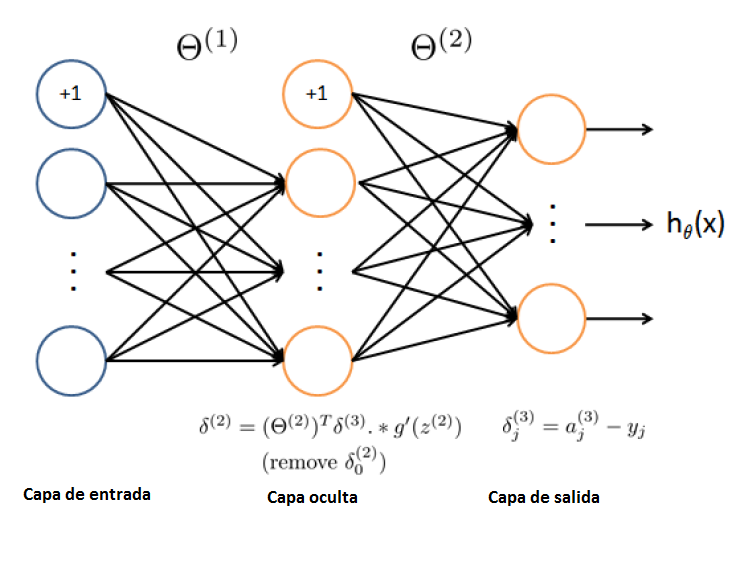

**Algoritmo para el cálculo de gradientes**

Vamos a acumular los gradientes para todos los ejemplos en  $\Delta^{(1)}_{ij}$ y $\Delta^{(2)}_{ij}$. De esta forma, luego simplemente debemos dividir el acumulado entre el número de ejemplos. Aunque podríamos hacerlo de forma matricial para todos a la vez, vamos a mantenerlo simple esta vez y trabajar ejemplo por ejemplo.

Inicializamos los gradientes $\Delta^{(1)}_{ij}$ y $\Delta^{(2)}_{ij}$ a 0.

Para cada ejemplo $i=0,...,m$
1. Calculamos el error en la capa de salida $$\delta^{(3)} = h_\Theta(x^{(i)})-y^{(i)}$$ (tener en cuenta que $y$ es un vector en este caso y por tanto tenemos el error en las 10 neuronas de salida).
2. Calculamos el error para la capa oculta $\delta^{(2)}$ propagando el error en la capa de salida $\delta^{(3)}$:
$$\delta^{(2)}=(\Theta^{(2)})^T·\delta^{(3)}.*g'(z^{(2)})$$ 
Para poder aplicar la fórmula debemos añadir una columna de unos a $z^{(2)}$, ya que sería lo correspondiente al bias (luego no lo tendremos en cuenta). Ten en cuenta que con "$.*$" nos referimos al producto elemento por elemento, mientras que con "$·$" estamos indicando el producto matricial.

3. Sumamos el valor del gradiente en cada caso al acumulador correspondiente
$$\Delta^{(l)}_{ij} = \Delta^{(l)}_{ij} + \delta^{(l+1)} (a^{(l)})^T$$

Es decir,
$$\Delta^{(1)}_{ij} = \Delta^{(1)}_{ij} + \delta^{(2)} (a^{(1)})^T$$ (eliminando el primer elemento de \delta^{(2)}$)
y
$$\Delta^{(2)}_{ij} = \Delta^{(2)}_{ij} + \delta^{(3)} (a^{(2)})^T$$

Finalmente, solo debemos calcular los gradientes $D^{(l)}_{ij}$ como
$$D^{(l)}_{ij} = \frac{\Delta^{(l)}_{ij}}{m}$$

In [22]:
def backprop(params, input_size, hidden_size, num_labels, X, y):
    ###################################################################
    # Copiar aquí el código de la función de coste sin regularización #
    ###################################################################
    m = X.shape[0]

    # desempaquetamos las matrices con los parámetros para cada capa
    theta1 = np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
    theta2 = np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))
    
    # Ejecutamos las propagación hacia adelante para obtener las salidas para cada ejemplo
    # a1, z2, a2, z3, h = ....
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

    # Calculamos el coste
    J = (1/m) * np.sum(-y*np.log(h)-(1-y)*np.log(1-h))
    
    ############################
    # Comienza Backpropagation #
    ############################
    # Inicializamos los acumuladores delta1  y delta2 a ceros, con las dismensiones de los theta1 y theta2
    # tendrán dimensiones (25, 401) y (10, 26), respectivamente
    delta1, delta2 = np.zeros_like(theta1), np.zeros_like(theta2)
    
    # Aunque podríamos vectorizarlo vamos a hacerlo para cada ejemplo
    for t in range(m):
        # Obtenemos lo que necesitamos del ejemplo (cálculos obtenidos en la propagación hacia adelante)
        # Para usar las fórmulas tal y como aparecen, vamos a coger todos los vectores en forma columna (resahpe(-1,1))
        a1t = a1[t,:].reshape(-1, 1)  # (401, 1)
        z2t = z2[t,:].reshape(-1, 1)  # (25, 1)
        a2t = a2[t,:].reshape(-1, 1)  # (26, 1)
        ht = h[t,:].reshape(-1, 1)  # (10, 1)
        yt = y[t,:].reshape(-1, 1)  # (10, 1)
        
        # Calculamos el error en la capa de salida (delta3), almacenar en d3t
        d3t = ht - yt

        # Para calcular el error en la capa oculta (delta2) necesitamos añadir un uno al inicio del vector z2
        # Crear z2t añadiendo a z2 el 1
        z2t = np.vstack((1, z2t))

        # Calculamos d2 a partir del error de la capa de salida, los parámetros en theta2 y el gradiente de z2t
        # Almacenar en d2t
        d2t = (theta2.T @ d3t) * sigmoid_gradient(z2t)

        # Ya podemos calcular los gradientes a partir de los errores
        # Para calcular el gradiente de los theta1, tenemos en cuenta el error en la capa oculta d2
        # Acumular el gradiente del ejemplo en delta1 y delta2
        delta1 = delta1 + (d2t[1:] @ a1t.T)
        delta2 = delta2 + d3t @ a2t.T

    # Calculamos el gradiente finalmente dividiendo entre el número de ejemplos
    delta1 /= m
    delta2 /= m

    # Para pasar los gradientes a minimize los ponemos en un vector
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

Uno de los aspectos donde hay que tener más cuidado es en la multiplicación de matrices y en sus dimensiones. Recuerda que debes diferenciar bien entre el producto de matrices elemento por elemento (`*` en numpy) y el producto de matrices tradicional (`dot()` en numpy).

Comprobemos que el resultado es el esperado.

In [23]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot)
print(J, grad.shape)
test_nb(list(np.round(grad[np.where(np.abs(grad)>0.0001)[0][:20]], 5)), 
                  [0.01986, 0.00014, 0.00018, 0.00011, 0.00023, 0.00033, 0.00037, 0.0004, 0.00046, 0.00057, 
                   0.00067, 0.00082, 0.00104, 0.00111, 0.00079, 0.00034, 0.00011, 0.00031, 0.00063, 0.00093], 
                  'Gradientes incorrectos')

6.8223773858037955 (10285,)
✔️ Test passed.


### Propagación hacia atrás - backpropagation - con regularización <a id="backprop_reg"></a>

Ahora queremos añadir la regularización al cáculo del gradiente. En este caso partimos de la función de coste con regularización, realizamos el mismo proceso de backpropagation y solo debemos añadir en el último paso la siguiente modificación:

Si $j\neq0$ entonces
$$D^{(l)}_{ij}= \frac{\Delta^{(l)}_{ij}}{m} + \frac{\lambda}{m}\Theta_{ij}^{(l)}$$
en otro caso
$$D^{(l)}_{ij}= \frac{\Delta^{(l)}_{ij}}{m}$$

Es decir, a las matrices $D^{(l)}_{ij}$ que ya hemos calculado en el paso anterior, en todas las columnas menos a la primera debemos sumarle el término de regularización correspondiente.

In [24]:
def backprop_reg(params, input_size, hidden_size, num_labels, X, y, lambda_reg):
    # Llama a la función backprop para calcular los gradientes
    J, grad = backprop(params, input_size, hidden_size, num_labels, X, y)

    # Ahora, desempaquetamos los pesos y los gradientes calculados en la funcion backprop
    # desempaquetamos las matrices con los parámetros para cada capa
    theta1 = np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
    theta2 = np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))

    # desempaquetamos las matrices con los gradientes para cada capa (igual que lo hacemos con los parámetros)
    delta1 = np.reshape(grad[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
    delta2 = np.reshape(grad[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))
    
    # Número de ejemplos
    m = X.shape[0]

    # Ya puedes añadir al coste y a los gradientes la regularización
    
    # Calcula el coste regularizado
    # Añadimos el término de regularización
    J += (lambda_reg/(2*m)) * (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2))

    # Calcula el gradiente con regularización
    # Añadimos el término de regularización en delta1 y delta2 (no regularizar el bias)
    delta1[:,1:] += (lambda_reg/m) * theta1[:,1:]
    delta2[:,1:] += (lambda_reg/m) * theta2[:,1:]

    # Para pasar los gradientes a minimize los ponemos en un vector
    grad = np.hstack((delta1.ravel(), delta2.ravel()))

    return J, grad

In [25]:
J, grad = backprop_reg(params, input_size, hidden_size, num_labels, X, y_onehot, lambda_reg)
print(J, grad.shape)
test_nb(list(np.round(grad[np.where(np.abs(grad)>0.0001)[0][:20]], 5)), 
                  [0.01986, 0.00015, 0.00016, 0.00013, 0.00022, 0.00033, 0.00036, 0.00039, 0.00048, 0.00057, 
                   0.00068, 0.00083, 0.00103, 0.00113, 0.00078, 0.00036, 0.00013, 0.00029, 0.00066, 0.00092], 
                  'Gradientes incorrectos')

6.827724308940754 (10285,)
✔️ Test passed.


## Entrenamiento de la red y clasificación <a id="entrenamiento"></a>

Ahora ya estamos listos para entrenar la red y usarla para hacer predicciones. Para entrenarla, utilizamos el método `minimize`de scipy, indicándole que backprop_reg es la función que calcula el coste y los gradientes.

> **Nota**: La ejecución de esta celda puede tardar unos minutos.

In [26]:
from scipy.optimize import minimize

# Minimizar la función objetivo que acabamos de definir
fmin = minimize(fun=backprop_reg, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, lambda_reg), 
                method='l-bfgs-b', jac=True, options={'maxiter': 250})
fmin

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 0.3158702042235359
        x: [-2.781e+00  1.100e-04 ... -1.591e+00  2.275e+00]
      nit: 250
      jac: [-6.060e-05  2.201e-08 ...  5.740e-05  3.520e-05]
     nfev: 258
     njev: 258
 hess_inv: <10285x10285 LbfgsInvHessProduct with dtype=float64>

Lógicamente hemos puesto un límite de iteraciones. Ahora, con el modelo obtenido vamos a tratar de realizar las predicciones para nuestros ejemplos de entrenamiento.

In [27]:
# Desempaquetamos los parámetros obtenidos como resultado del entrenamiento almacenados en fmin.x
# Crea las variables theta1 y theta2
theta1 = np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
theta2 = np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))

# Utilizamos los parámetros desempaquetados con la propagación hacia adelante para obtener la predicción para nuestros ejemplos
# a1, z2, a2, z3, h = ...
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

# Finalmente, para obtener la clase para cada ejemplo, buscamos de las diez salidas cual es la más alta
# y usamos su índice como valor predicho (utilizar np.argmax con axis=1 que hace precísamente eso).
# y_pred = 
y_pred = np.argmax(h, axis=1)


Finalmente, podemos calcular la precisión del modelo en entrenamiento para ver cómo de bien está funcionando.

In [28]:
acc_train = metrics.accuracy_score(y_pred, y)

print("Precisión en train: {}%".format(acc_train*100))

# Según el sistema operativo, podemos obtener dos resultados diferentes
test_nb((np.round(acc_train,2) == 0.97) or (np.round(acc_train,3) == 0.995), True, 'Precisión incorrecta')

Precisión en train: 99.48%
✔️ Test passed.


## Parte opcional

Los ejercicios anteriores permiten, si se completan perfectamente, alcanzar un 7 en esta práctica (notable). La siguiente parte se valora 1.5 puntos, al igual que el Notebook sobre PyTorch.

### Visualización de errores

El error que obtenemos es muy bajo. ¿Pero qué ejemplos estamos fallando? ¿El ojo humano los diferenciaría? Obtén los ejemplos que se están fallando y píntalos como hemos hecho al principio junto con la clase real del ejemplo y la clase que le asigna la red. ¿Serías capaz de hacerlo mejor que la propia red neuronal?


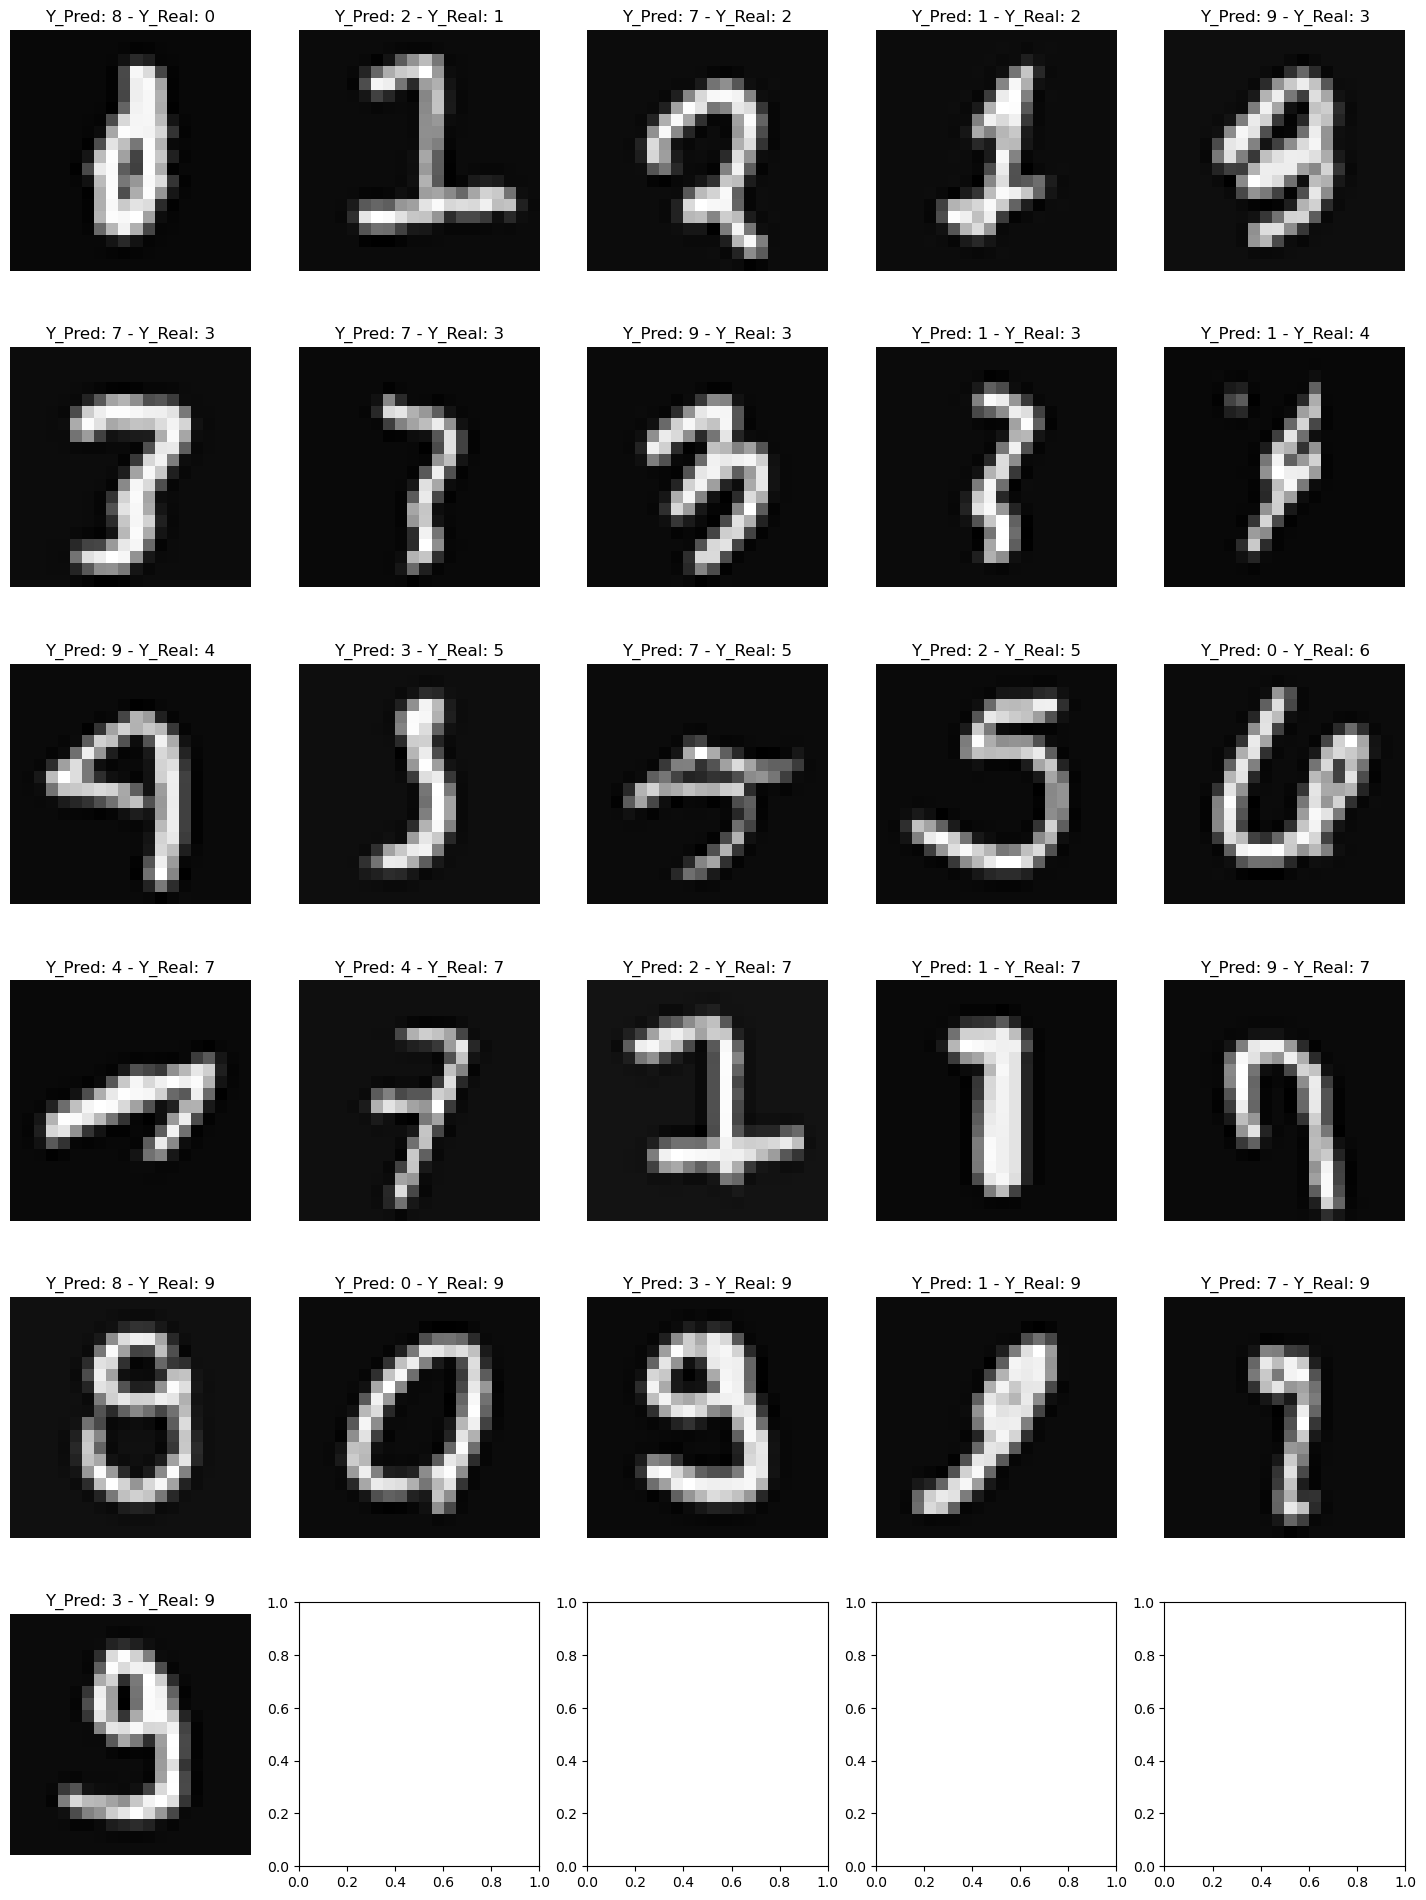

In [29]:
fallados = []

for i in range(y_pred.shape[0]):
    if y_pred[i] != y[i]:
        fallados.append((i, y_pred[i]))

size = int(len(fallados))
col = len(fallados)//5
row = int(np.ceil(size / col))
fig, axes = plt.subplots(row, col, figsize=(18, row * 4))

for degree in range(size):
    index = fallados[degree][0]
    img = X[index, :].reshape(20, 20, order='F')
    axes.ravel()[degree].imshow(img, cmap=plt.cm.gray)
    axes.ravel()[degree].set_title(f'Y_Pred: {int(fallados[degree][1])} - Y_Real: {int(y.flat[index])}')
    axes.ravel()[degree].axis('off')

### Redes neuronales en scikit-learn

Sklearn dispone de una implementación de una red neuronal sencilla, [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Entre los parámetros más de esta clase, encontramos los siguientes:

* `activation`: string con el nombre de la función de activación que vamos a utilizar. Las opciones son `'identity'` (para no utilizar función de activación), `'logistic'` (para utilizar la función sigmoide), `'tanh'` (para utilizar la función tangente hiperbólico) y `'relu'` (para utilizar la función relu). `'relu'` es la opción por defecto.
* `hidden_layer_sizes`: Una tupla que representa el número de neuronas en cada capa oculta. Por ejemplo, `(100, 50)` indica dos capas ocultas con 100 y 50 neuronas respectivamente. El valor por defecto es `(100,)`, es decir, una capa oculta con 100 neuronas.
* `solver`: El optimizador que se utilizará para ajustar los pesos. Las opciones incluyen `'lbfgs'` (método quasi-Newton), `'sgd'` (descenso de gradiente estocástico) y `'adam'` (un optimizador estocástico basado en gradiente). `'adam'` es la opción por defecto.
* `alpha`: Parámetro de regularización. Valores más altos implican una mayor regularización. El valor por defecto es `0.0001`.
* `max_iter`: Número máximo de iteraciones del descenso por gradiente. El valor por defecto es `200`.
* `random_state`: Semilla para el generador de números aleatorios. Importante para asegurar que conseguimos resultados reproducibles.


En la siguiente celda, vamos a utilizar la clase `MLPClassifier` para probar diferentes tamaños de la capa oculta y ver qué error da cada uno. Debes seguir estos pasos:

 - Crea la red a través del constructor de `MLPClassifier`. Utilizaremos los parámetros:
   - `solver`: `'lbfgs'`.
   - `hidden_layer_sizes`: utilizaremos una única capa oculta e iremos variando su tamaño.
   - `max_iter`: `250`.
   
 - Emplea la función `.fit()` del clasificador para entrenar la red. Le pasaremos los datos de entrenamiento, `X` e `y`, utilizando la versión de `y` original (no hace falta realizar el one hot encoding, se realiza internamente).
 - Emplea la función `.predict()` sobre los datos de entrenamiento, para obtener un `y_pred` con el que comparar la precisión.
 
Tras realizar los experimentos, responde a estas preguntas: ¿El tamaño de la capa oculta influye mucho en la precisión final? ¿Cuantas neuronas hacen falta en la capa oculta, aproximadamente, para modelar estos datos?

> **Nota**: Para tamaños pequeños de la capa oculta sklearn nos dará un warning, indicando que hemos alcanzado el máximo de iteraciones. Puedes ignorarlo, no es problema.

> **Nota**: La ejecución de esta celda puede tardar unos minutos.


/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to c

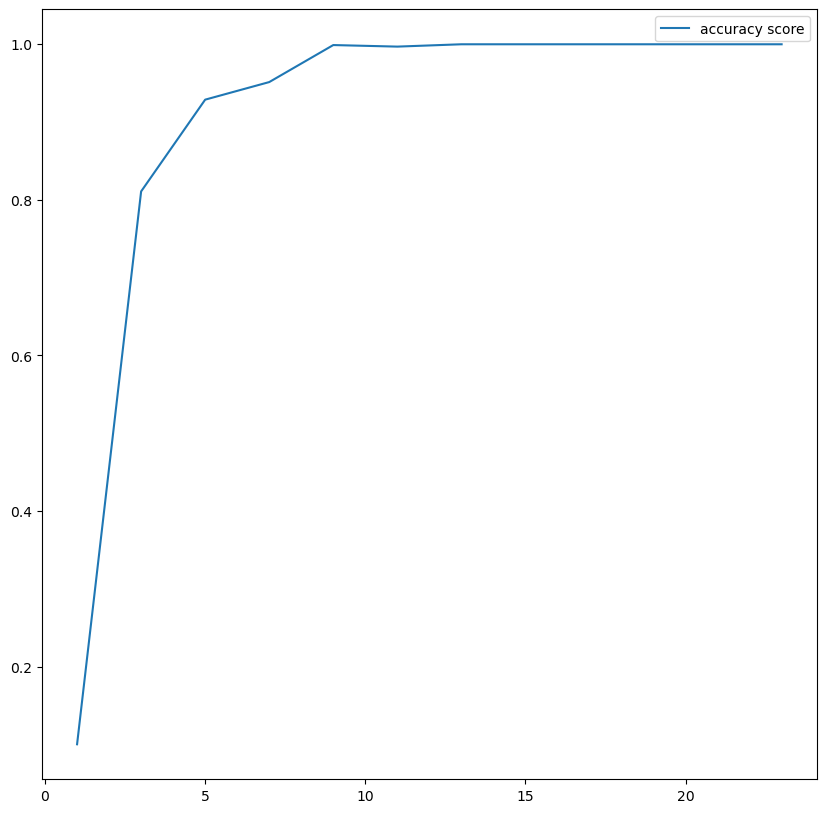

In [30]:
from sklearn.neural_network import MLPClassifier

hidden_sizes = range(1, 25, 2)
accuracies = np.zeros(len(hidden_sizes))

for s, size in enumerate(hidden_sizes):
    # Crea el clasificador con size neuronas en la capa oculta.
    # Después entrénalo, y obten la precisión en los datos de entrenamiento.
    # Guarda la precisión final en una variable acc_train.
    mlpc = MLPClassifier(solver='lbfgs', hidden_layer_sizes=size, max_iter=250)
    mlpc.fit(X, y.ravel())
    y_pred = mlpc.predict(X)
    acc_train = metrics.accuracy_score(y, y_pred)

    accuracies[s] = acc_train

# Muestra en una gráfica como ha cambiado el error conforme aumentábamos hidden_sizes
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(hidden_sizes, accuracies, label="accuracy score")
ax.legend()

RESPONDE AQUÍ A LAS PREGUNTAS

### Otras librerías

Para grandes problemas solemos emplear librerías especializadas en redes neuronales. Las dos más famosas son [PyTorch](https://pytorch.org/) y [TensorFlow](https://www.tensorflow.org/). Puedes investigar más sobre ambas en su documentación, donde encontrarás tutoriales muy completos. Quizás PyTorch es la librería más sencilla de comenzar a trabajar.  En el otro Notebook de esta práctica encontrarás una primera introducción a PyTorch. También puedes revisar los tutoriales de su página para intentar crear una red sencilla: https://pytorch.org/tutorials/